In [1]:
# IMDB Movie Review Sentiment Analysis
# All imports consolidated at the top

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

# Natural Language Processing
import nltk
from nltk.corpus import stopwords

# Text processing
import re

# System
import warnings

print("✅ All imports loaded successfully!")
print("📊 Ready for sentiment analysis...")

✅ All imports loaded successfully!
📊 Ready for sentiment analysis...


In [2]:
# --- 1. LOAD DATA ---

df = pd.read_csv('IMDB_sample.csv.xls')
print(df.head())

   Unnamed: 0                                             review  label
0       18245  This short spoof can be found on Elite's Mille...      0
1       19801  A singularly unfunny musical comedy that artif...      0
2        3222  An excellent series, masterfully acted and dir...      1
3        6010  The master of movie spectacle Cecil B. De Mill...      1
4       16355  I was gifted with this movie as it had such a ...      0


In [3]:
# --- 2. PREPROCESSING ---
# Download required NLTK data (must be done after import)
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove HTML tags and special characters
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return " ".join(tokens)

df['clean_text'] = df['review'].apply(clean_text)
print("Sample of cleaned text:")
print(df['clean_text'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Sample of cleaned text:
0    short spoof found elites millennium edition dv...
1    singularly unfunny musical comedy artificially...
2    excellent series masterfully acted directed un...
3    master movie spectacle cecil mille goes west u...
4    gifted movie great premise friendship three wo...
Name: clean_text, dtype: object


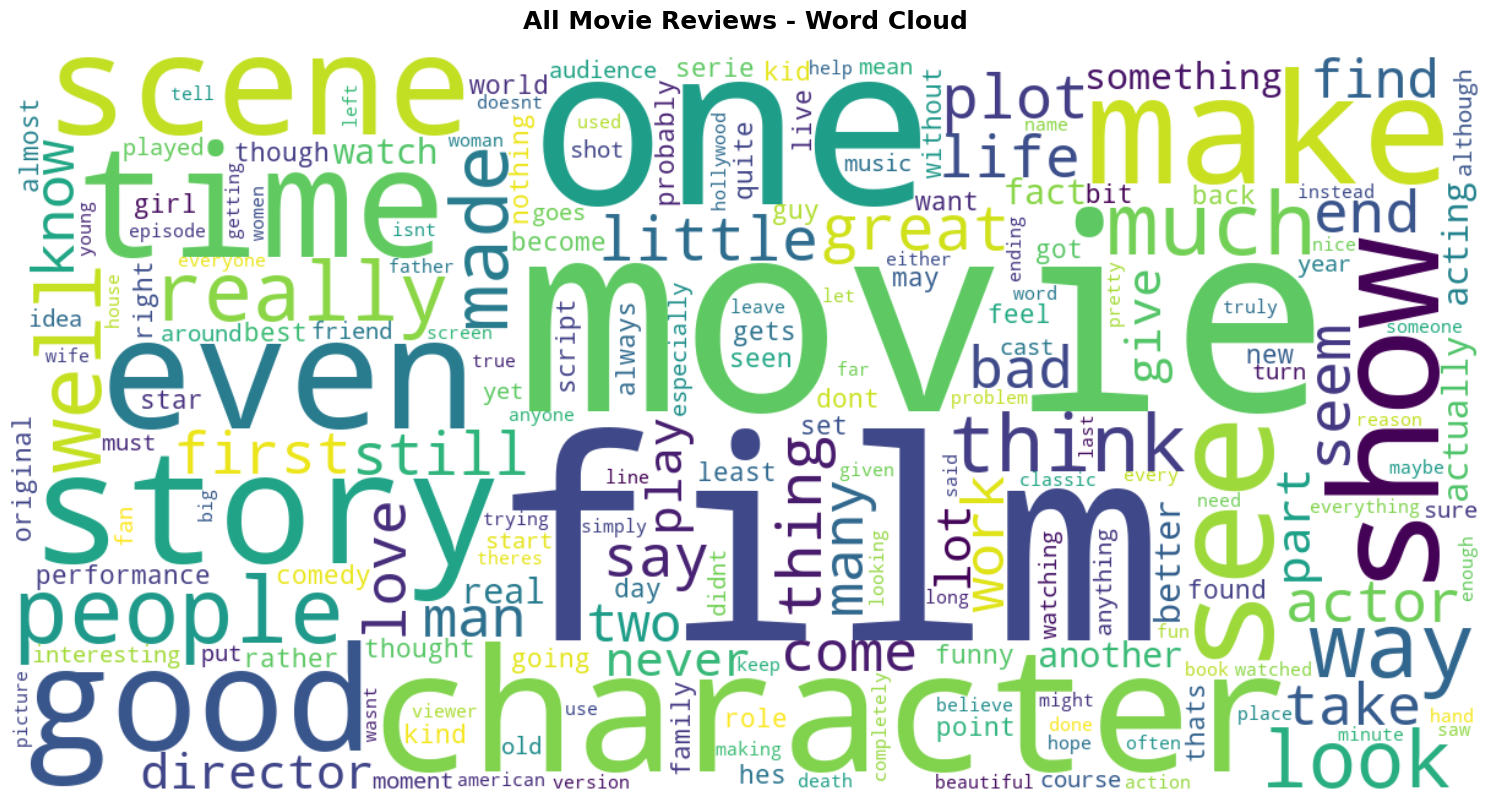

Total reviews count: 7501
Positive reviews count: 3719
Negative reviews count: 3782


In [4]:
# --- 3. WORDCLOUD ---
# Combine all reviews into one text
all_text = " ".join(df['clean_text'])

# Create wordcloud for all reviews
all_wordcloud = WordCloud(width=1200, height=600, background_color='white', 
                         max_words=200, colormap='viridis').generate(all_text)

plt.figure(figsize=(15,8))
plt.title("All Movie Reviews - Word Cloud", fontsize=18, fontweight='bold', pad=20)
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

print(f"Total reviews count: {len(df)}")
print(f"Positive reviews count: {len(df[df['label']==1])}")
print(f"Negative reviews count: {len(df[df['label']==0])}")

In [5]:
# --- 4. SPLIT DATA ---

X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'])

In [6]:
# --- 5. TF-IDF ---

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

=== WORD CLASSIFICATION ANALYSIS ===
Analyzing words that contribute to positive/negative sentiment...

🔴 MOST POSITIVE WORDS (contribute to positive sentiment):
  great: 2.8152
  excellent: 2.6299
  best: 2.2845
  favorite: 2.0757
  also: 1.8887
  well: 1.7796
  love: 1.6576
  wonderful: 1.5695
  quite: 1.4133
  entertaining: 1.3910
  fun: 1.3753
  perfect: 1.3714
  shows: 1.3562
  recommend: 1.2711
  beautiful: 1.2611

🔵 MOST NEGATIVE WORDS (contribute to negative sentiment):
  worse: -1.6675
  horrible: -1.7499
  dull: -1.7630
  fails: -1.8486
  nothing: -1.9962
  poor: -2.0032
  instead: -2.0037
  disappointment: -2.0044
  annoying: -2.0108
  boring: -2.0578
  terrible: -2.1250
  waste: -2.3012
  awful: -2.8237
  worst: -3.2506
  bad: -3.2817


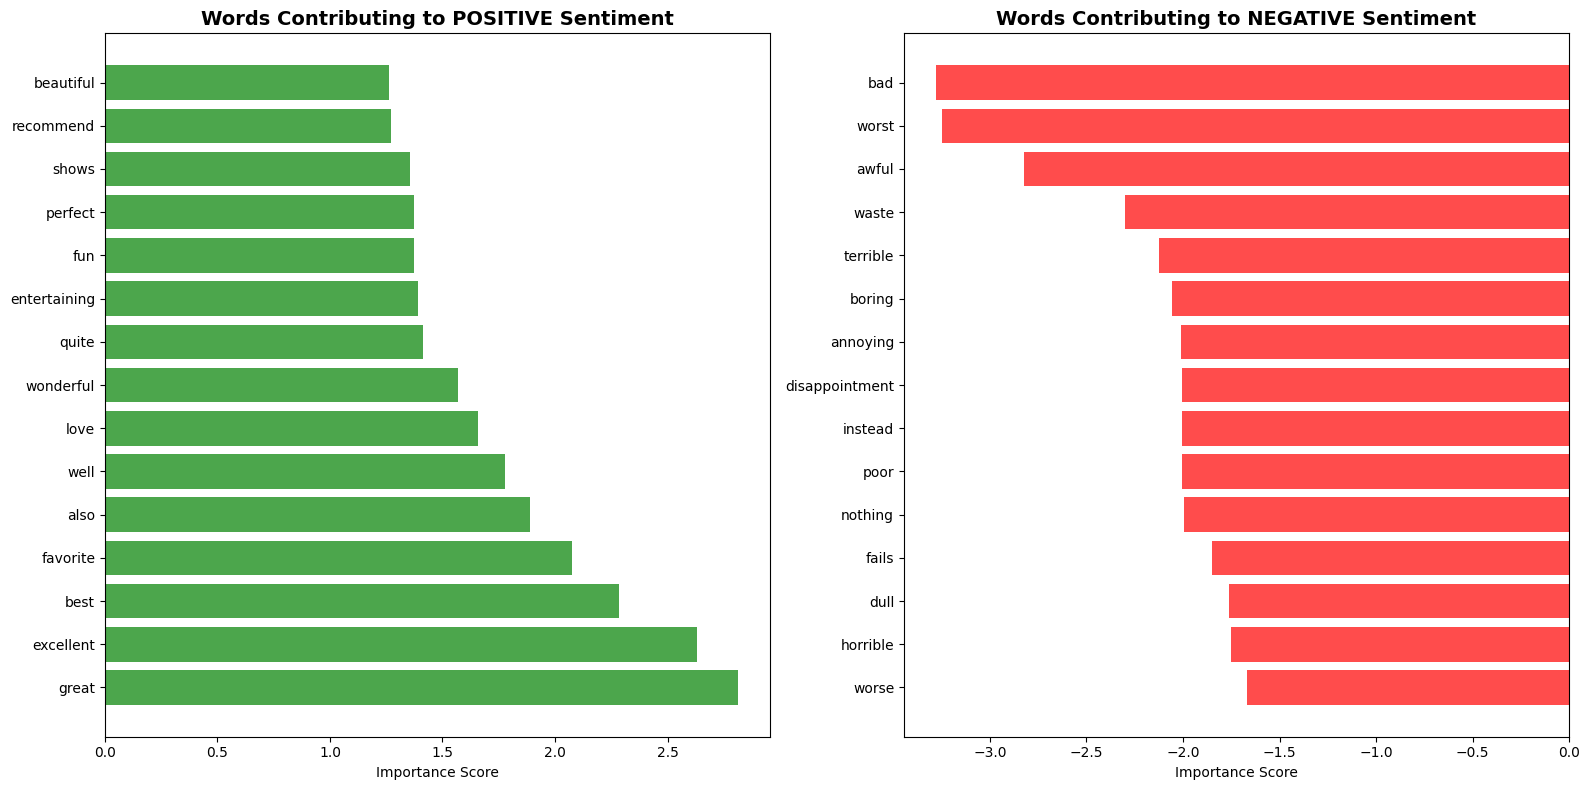

In [7]:
# --- 6. WORD CLASSIFICATION EVALUATION ---
# After training models, let's analyze which words contribute to positive/negative classification

def analyze_word_importance(model, tfidf, feature_names, top_n=20):
    """Analyze which words are most important for positive/negative classification"""
    
    # Get feature importance (coefficients for linear models)
    if hasattr(model, 'coef_'):
        # For SVM and other linear models
        coef = model.coef_[0]
    elif hasattr(model, 'feature_log_prob_'):
        # For Naive Bayes - calculate log probability difference
        coef = model.feature_log_prob_[1] - model.feature_log_prob_[0]
    else:
        print(f"Model {type(model).__name__} doesn't support coefficient analysis")
        return None, None
    
    # Get top positive and negative features
    feature_importance = list(zip(feature_names, coef))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    positive_words = feature_importance[:top_n]
    negative_words = feature_importance[-top_n:]
    
    return positive_words, negative_words

# Use the best performing model for analysis
print("=== WORD CLASSIFICATION ANALYSIS ===")
print("Analyzing words that contribute to positive/negative sentiment...\n")

# Get feature names from TF-IDF
feature_names = tfidf.get_feature_names_out()

# Analyze with SVM (usually performs well for text classification)
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

positive_words, negative_words = analyze_word_importance(svm_model, tfidf, feature_names, top_n=15)

if positive_words and negative_words:
    print("🔴 MOST POSITIVE WORDS (contribute to positive sentiment):")
    for word, score in positive_words:
        print(f"  {word}: {score:.4f}")
    
    print(f"\n🔵 MOST NEGATIVE WORDS (contribute to negative sentiment):")
    for word, score in negative_words:
        print(f"  {word}: {score:.4f}")
    
    # Visualize word importance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Positive words
    pos_words, pos_scores = zip(*positive_words)
    ax1.barh(range(len(pos_words)), pos_scores, color='green', alpha=0.7)
    ax1.set_yticks(range(len(pos_words)))
    ax1.set_yticklabels(pos_words)
    ax1.set_title('Words Contributing to POSITIVE Sentiment', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Importance Score')
    
    # Negative words
    neg_words, neg_scores = zip(*negative_words)
    ax2.barh(range(len(neg_words)), neg_scores, color='red', alpha=0.7)
    ax2.set_yticks(range(len(neg_words)))
    ax2.set_yticklabels(neg_words)
    ax2.set_title('Words Contributing to NEGATIVE Sentiment', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Importance Score')
    
    plt.tight_layout()
    plt.show()


=== MODEL PERFORMANCE COMPARISON ===

🔹 Naive Bayes
   Accuracy: 0.8625 (86.25%)
   Confusion Matrix:
   [[ 832  132]
    [ 126  786]]
   Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87       964
    Positive       0.86      0.86      0.86       912

    accuracy                           0.86      1876
   macro avg       0.86      0.86      0.86      1876
weighted avg       0.86      0.86      0.86      1876

------------------------------------------------------------
🔹 SVM
   Accuracy: 0.8689 (86.89%)
   Confusion Matrix:
   [[ 822  142]
    [ 104  808]]
   Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.85      0.87       964
    Positive       0.85      0.89      0.87       912

    accuracy                           0.87      1876
   macro avg       0.87      0.87      0.87      1876
weighted avg       0.87      0.87      0.87      1876

---------

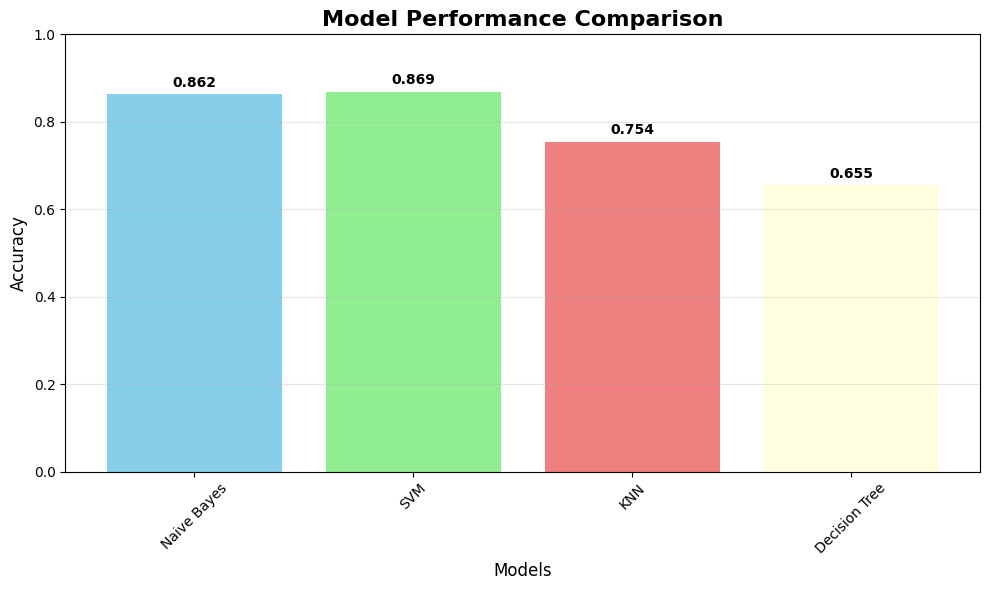

In [8]:
# --- 6. MODEL & EVALUASI ---

models = {
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

results = {}

print("=== MODEL PERFORMANCE COMPARISON ===\n")

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {'model': model, 'accuracy': accuracy, 'predictions': y_pred}
    
    print(f"🔹 {name}")
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"   [[{cm[0,0]:4d} {cm[0,1]:4d}]")
    print(f"    [{cm[1,0]:4d} {cm[1,1]:4d}]]")
    print(f"   Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    print("-" * 60)

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   Best Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Visualize model performance
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()